## Построение модельного ряда, вычисление скользящего среднего и скользящей медианы

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import pandas as pd  # Для экспоненциального сглаживания

k_max = 500
h = 0.05
k = np.arange(0, k_max + 1)
true_trend = np.sqrt(k * h)  # Истинный тренд: sqrt(k * h)

np.random.seed(42)
noise = np.random.normal(0, 1, size=len(k))
x = true_trend + noise  # Модельный ряд x_k

# Окна
windows = [21, 51, 111]
m_values = [10, 25, 55]  # m для каждого окна

#SMA
def simple_moving_average(x, m):
    n = len(x)
    y = np.zeros(n)
    for k in range(n):
        # Определяем границы окна
        start = max(0, k - m)  # Левая граница, не выходящая за 0
        end = min(n, k + m + 1)  # Правая граница, не выходящая за n
        window_size = end - start  # Фактический размер окна
        if window_size > 0:
            y[k] = sum(x[start:end]) / window_size
    return y

# Вычисление SMA для каждого окна
ma_trends = {}
for w, m in zip(windows, m_values):
    ma_trends[w] = simple_moving_average(x, m)


# Функция для вычисления скользящей медианы вручную
def moving_median(x, m):
	n = len(x)
	y = np.zeros(n)  # Инициализация массива для сглаженных значений
	for k in range(n):
		# Определяем границы окна
		start = max(0, k - m)  # Левая граница, не выходящая за 0
		end = min(n, k + m + 1)  # Правая граница, не выходящая за n
		window_size = end - start  # Фактический размер окна

		if window_size > 0:
			# Извлекаем значения в окне
			window = x[start:end]
			# Сортируем и берём медиану
			y[k] = np.median(window)
	return y


# Вычисление скользящей медианы для каждого окна
median_trends = {}
for w, m in zip(windows, m_values):
	median_trends[w] = moving_median(x, m)


## Построение графиков

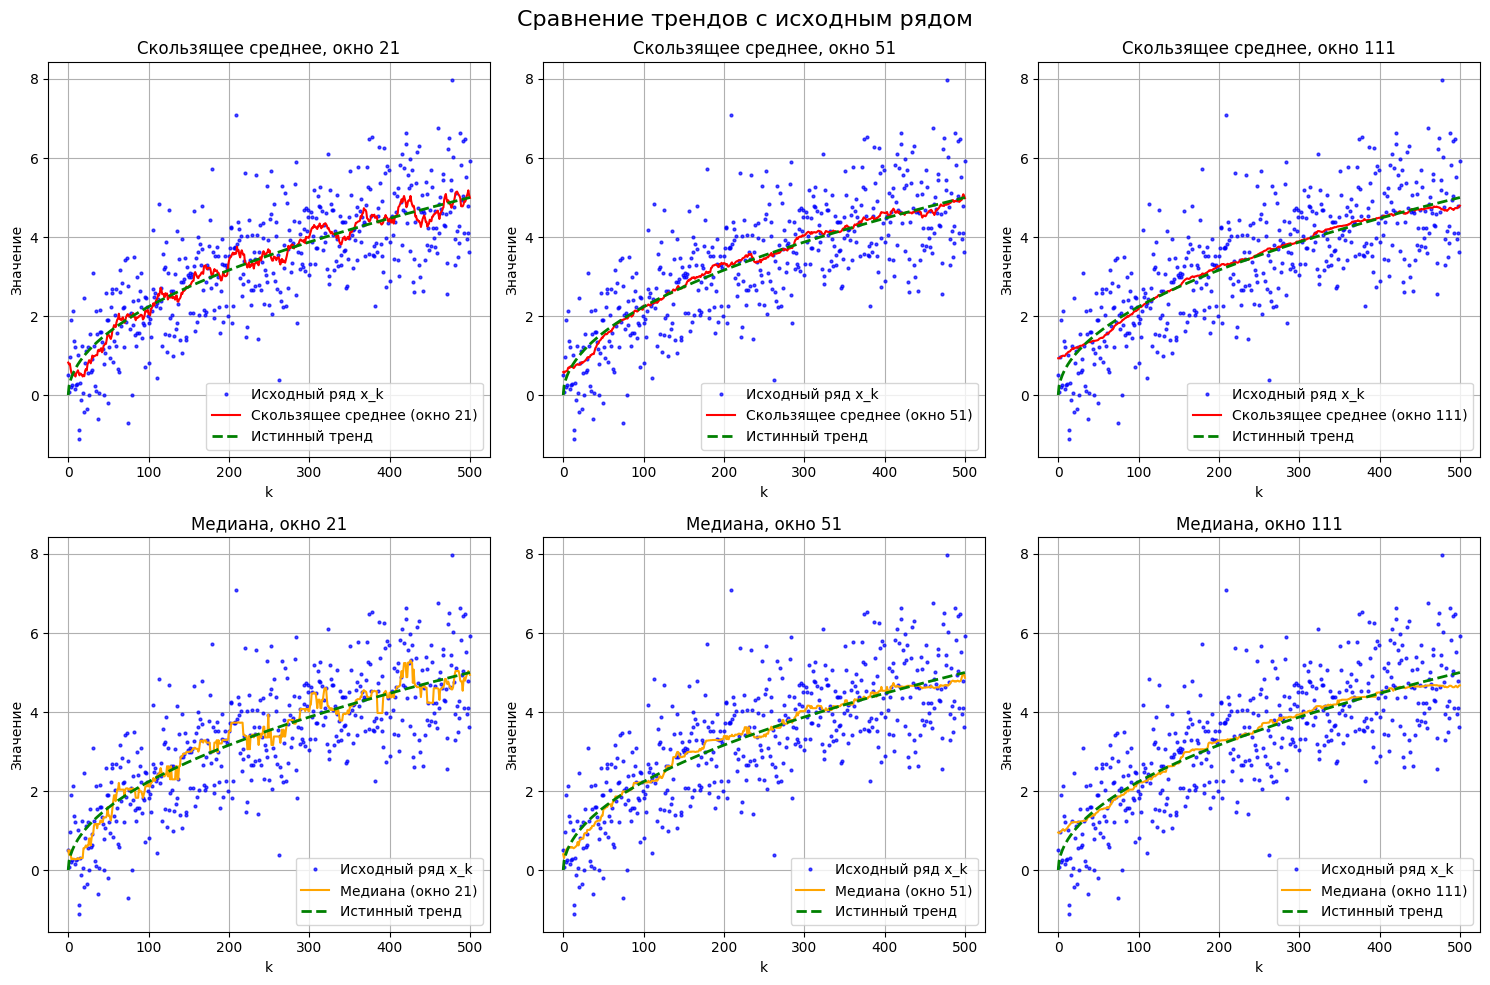

In [2]:
# Графики для каждого окна: исходный ряд + тренды (MA и ES) + истинный
fig, axes = plt.subplots(2, len(windows), figsize=(15, 10))
fig.suptitle('Сравнение трендов с исходным рядом', fontsize=16)

for idx, w in enumerate(windows):
	axes[0, idx].plot(k, x, 'bo', alpha=0.7, label='Исходный ряд x_k', linewidth=0.2, ms=2)
	axes[0, idx].plot(k, ma_trends[w], 'r-', label=f'Скользящее среднее (окно {w})', linewidth=1.5)
	axes[0, idx].plot(k, true_trend, 'g--', label='Истинный тренд', linewidth=2)
	axes[0, idx].set_title(f'Скользящее среднее, окно {w}')
	axes[0, idx].set_xlabel('k')
	axes[0, idx].set_ylabel('Значение')
	axes[0, idx].legend()
	axes[0, idx].grid(True)

	axes[1, idx].plot(k, x, 'bo', alpha=0.7, label='Исходный ряд x_k', linewidth=0.8, ms=2)
	axes[1, idx].plot(k, median_trends[w], 'orange', label=f'Медиана (окно {w})', linewidth=1.5)
	axes[1, idx].plot(k, true_trend, 'g--', label='Истинный тренд', linewidth=2)
	axes[1, idx].set_title(f'Медиана, окно {w}')
	axes[1, idx].set_xlabel('k')
	axes[1, idx].set_ylabel('Значение')
	axes[1, idx].legend()
	axes[1, idx].grid(True)

plt.tight_layout()
plt.show()

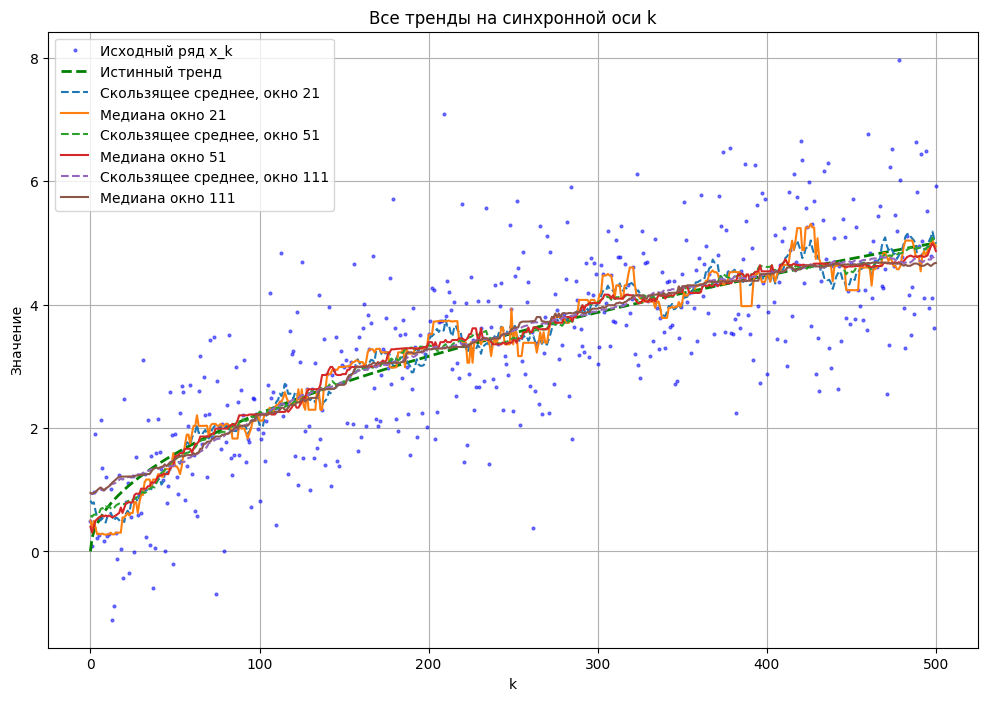

In [3]:
# Дополнительный график: все тренды на одном графике для сравнения (для MA)
plt.figure(figsize=(12, 8))
plt.plot(k, x, 'bo', alpha=0.5, label='Исходный ряд x_k', linewidth=0.8, ms=2)
plt.plot(k, true_trend, 'g--', label='Истинный тренд', linewidth=2)
for w in windows:
	plt.plot(k, ma_trends[w], '--', label=f'Скользящее среднее, окно {w}', linewidth=1.5)
	plt.plot(k, median_trends[w], '-', label=f'Медиана окно {w}', linewidth=1.5)
plt.title('Все тренды на синхронной оси k')
plt.xlabel('k')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Функция для подсчета числа поворотных точек (p)
def count_turning_points(series):
	n = len(series)
	if n < 3:
		return 0
	p = 0
	for i in range(1, n - 1):
		if (series[i - 1] < series[i] > series[i + 1]) or (series[i - 1] > series[i] < series[i + 1]):
			p += 1
	return p


# Функция для вычисления ожидаемого и дисперсии для p
def expected_var_p(n):
	if n < 3:
		return 0, 0
	ep = (2 / 3) * (n - 2)
	return ep


# Функция для коэффициента Кендалла (tau) - корреляция между временем и значениями
def kendall_tau_time(series, time):
	tau, p_value = kendalltau(time, series)
	return tau, p_value


# Вычисление остатков и проверка на случайность
n = len(x)
results = {}

for method, trends in [('SMA', ma_trends), ('Median', median_trends)]:
	results[method] = {}
	for w in windows:
		trend = trends[w]
		residuals = x - trend  # Остатки

		# Поворотные точки
		p = count_turning_points(residuals)
		ep = expected_var_p(n)

		# Кендалл tau
		tau, pval_tau = kendall_tau_time(residuals, k)


		results[method][w] = {
			'p': p,
			'ep': ep,
			'tau': tau,
		}

# Вывод результатов
print("Проверка остатков на случайность:")
for method, trend_results in results.items():
	print(f"\nМетод: {method}")
	for w, res in trend_results.items():
		print(f"  Окно {w}:")
		print(
			f"    Поворотные точки: p={res['p']:.1f}, E(p)={res['ep']:.1f}")
		print(
			f"    Кендалл tau: τ={res['tau']:.4f}")

Проверка остатков на случайность:

Метод: SMA
  Окно 21:
    Поворотные точки: p=337.0, E(p)=332.7
    Кендалл tau: τ=-0.0049
  Окно 51:
    Поворотные точки: p=337.0, E(p)=332.7
    Кендалл tau: τ=0.0024
  Окно 111:
    Поворотные точки: p=335.0, E(p)=332.7
    Кендалл tau: τ=0.0315

Метод: Median
  Окно 21:
    Поворотные точки: p=333.0, E(p)=332.7
    Кендалл tau: τ=-0.0021
  Окно 51:
    Поворотные точки: p=336.0, E(p)=332.7
    Кендалл tau: τ=0.0122
  Окно 111:
    Поворотные точки: p=335.0, E(p)=332.7
    Кендалл tau: τ=0.0413


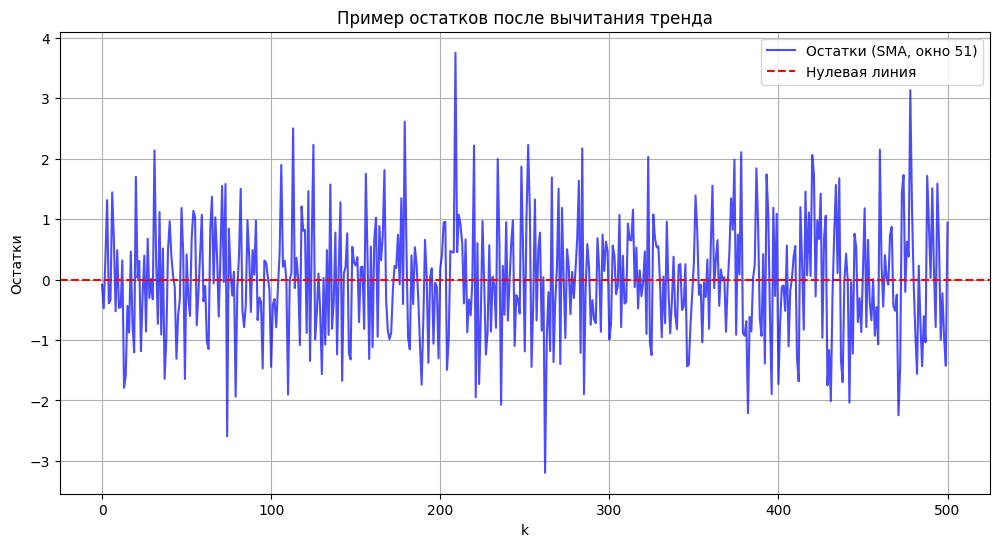

In [5]:
# График примера остатков (для SMA окно 51)
plt.figure(figsize=(12, 6))
residuals_example = x - ma_trends[51]
plt.plot(k, residuals_example, 'b-', alpha=0.7, label='Остатки (SMA, окно 51)')
plt.axhline(y=0, color='r', linestyle='--', label='Нулевая линия')
plt.title('Пример остатков после вычитания тренда')
plt.xlabel('k')
plt.ylabel('Остатки')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Вычисление MSE для сравнения с истинным трендом
mse_ma = {w: np.mean((ma_trends[w] - true_trend) ** 2) for w in windows}
mse_median = {w: np.mean((median_trends[w] - true_trend) ** 2) for w in windows}

print("\nMSE для скользящего среднего:")
for w, mse in mse_ma.items():
    print(f"Окно {w}: {mse:.4f}")

print("\nMSE для скользящей медианы:")
for w, mse in mse_median.items():
    print(f"Окно {w}: {mse:.4f}")


MSE для скользящего среднего:
Окно 21: 0.0428
Окно 51: 0.0142
Окно 111: 0.0157

MSE для скользящей медианы:
Окно 21: 0.0708
Окно 51: 0.0195
Окно 111: 0.0197
